<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-2" data-toc-modified-id="Problem-2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem 2</a></span><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Loading-dataset" data-toc-modified-id="Loading-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Loading dataset</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Visualization</a></span></li><li><span><a href="#Dataset-Embedding" data-toc-modified-id="Dataset-Embedding-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Dataset Embedding</a></span></li><li><span><a href="#Simple-MLP" data-toc-modified-id="Simple-MLP-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Simple MLP</a></span><ul class="toc-item"><li><span><a href="#Model-instantiation" data-toc-modified-id="Model-instantiation-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Model instantiation</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-1.7.3"><span class="toc-item-num">1.7.3&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.7.4"><span class="toc-item-num">1.7.4&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-1.7.4.1"><span class="toc-item-num">1.7.4.1&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Visualizing-samlpes" data-toc-modified-id="Visualizing-samlpes-1.7.4.2"><span class="toc-item-num">1.7.4.2&nbsp;&nbsp;</span>Visualizing samlpes</a></span></li></ul></li></ul></li><li><span><a href="#MLP-with-Dropout" data-toc-modified-id="MLP-with-Dropout-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>MLP with Dropout</a></span><ul class="toc-item"><li><span><a href="#Question" data-toc-modified-id="Question-1.8.1"><span class="toc-item-num">1.8.1&nbsp;&nbsp;</span>Question</a></span></li></ul></li></ul></li></ul></div>

# Problem 2
Please fill todo parts of this code. 
You can change any part of the code that you think it is needed but we do not suggest that. 

After you filled the todo parts please run the whole network one time and then upload your results. 

## Import
Import your required libraries in this cell. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
import itertools

## Loading dataset

In [2]:
# transforms
transform = transforms.Compose([transforms.ToTensor()])
# datasets
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

## Parameters

In [3]:
writer = SummaryWriter('./simple-MLP')
BATCH_SIZE = 128
N_EPOCH = 20
sample_size = 6

## Model 

In [4]:
class MLPModel(nn.Module):
    def __init__(self, network, criterion):
        super().__init__()
        self.network = network
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-3)
        self.criterion = criterion
        
    def forward(self, x):
        return self.network(x)
    
    def calculate_accuracy(self, outputs, true_labels):
        accuracy = np.sum(outputs.detach().numpy() == true_labels.detach().numpy()) / len(outputs)
        return accuracy
        
    def fit(self, train_data, batch_size, n_epoch, tensorboard_writer=None):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        n_iter = 0
        self.train()
        for epoch in range(n_epoch):
            for i, data in enumerate(train_loader):
                inputs, labels = data
                prediction_outputs = self.network(inputs)
                loss = self.criterion(prediction_outputs, labels)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                prediction_lables = torch.argmax(prediction_outputs, dim=-1)
                accuracy = self.calculate_accuracy(prediction_lables, labels)
                if tensorboard_writer is not None:
                    tensorboard_writer.add_scalar('Loss/train', loss, n_iter)
                    tensorboard_writer.add_scalar('Accuracy/train', accuracy, n_iter)
                    n_iter += 1
            print('Epoch {}:'.format(epoch + 1))
            self.evaluate(train_data, trainset.data.size(0))
    
    def evaluate(self, evaluation_data, batch_size):
        self.eval()
        evaluation_loader = DataLoader(evaluation_data, batch_size=batch_size, shuffle=False)
        inputs, labels = iter(evaluation_loader).next()
        prediction_labels = torch.argmax(self.network(inputs), dim=-1)
        accuracy = self.calculate_accuracy(prediction_labels, labels)
        print('Accuracy: {}'.format(accuracy))
        
    def predict(self, prediction_data, batch_size):
        self.eval()
        prediction_loader = DataLoader(prediction_data, batch_size=batch_size, shuffle=False)
        inputs, labels = iter(prediction_loader).next()
        prediction_outputs = self.network(inputs)
        prediction_probs, prediction_labels = torch.max(prediction_outputs, dim=-1)
        return labels, prediction_labels, prediction_probs

## Visualization
**Help**: you can read about confusion matrix [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). 

In [5]:
def plot_conf_mat(true_labels, predicted_labels):
    '''
    This function take true and predicted labels and plot the confusion matrix. 
    '''
    fig = plt.figure(figsize=(10, 8))
    conf = confusion_matrix(true_labels, predicted_labels)
    conf = conf / conf.sum(axis=1)[:, None]
    plt.imshow(conf, cmap=plt.cm.Greens)
    plt.colorbar()
    plt.title('Confusion matrix')
    classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
    plt.xticks(np.arange(10), classes)
    plt.yticks(np.arange(10), classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
        plt.text(j, i, conf[i, j], horizontalalignment='center')
    plt.tight_layout()
    plt.show()
    return fig

def plot_classes_preds(images, prediction_probs, prediction_labels, true_labels, num_sample, classes):
    fig = plt.figure(figsize=(15, 10))
    perm = torch.randperm(len(images))
    for idx in np.arange(num_sample):
        ax = fig.add_subplot(1, num_sample, idx + 1, xticks=[], yticks=[])
        plt.imshow(images[perm][idx], cmap=plt.cm.Greys)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[prediction_labels[perm][idx]],
            prediction_probs[perm][idx] * 100.0,
            classes[true_labels[perm][idx]]),
                    color=("green" if prediction_labels[perm][idx]==true_labels[perm][idx].item() else "red"))
    plt.show()
    return fig

## Dataset Embedding
This part embeds your input features in 2 or 3 dimensions. You can see the results in the tensorboard log. 
You do **not** need to do anything in this part. 

In [6]:
def select_n_random(data, labels, n=100):
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(trainset.data, trainset.targets)
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.close()

## Simple MLP
This network has 3 hidden layers and one output layer. 

**hidden layers**
* linear layer with 256 neurons and tanh activation function.
* linear layer with 128 neurons and tanh activation function.
* linear layer with 100 neurons and tanh activation function.

**Output layer**
* 10 neurons output with softmax activation. 

### Model instantiation

In [7]:
layers = [nn.Flatten(), nn.Linear(28 * 28, 256), nn.Tanh(), nn.Linear(256, 128), nn.Tanh(), nn.Linear(128, 100), nn.Tanh(), nn.Linear(100, 10), nn.Softmax(dim=1)]
network = nn.Sequential(*layers)
criterion = nn.CrossEntropyLoss()
simple_MLP_model = MLPModel(network, criterion)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
images, labels = iter(train_loader).next()
writer.add_graph(network, images)
writer.close()

### Training

In [8]:
simple_MLP_model.fit(trainset, BATCH_SIZE, N_EPOCH, writer)

Epoch 1:
Accuracy: 0.7785666666666666
Epoch 2:
Accuracy: 0.8433333333333334
Epoch 3:
Accuracy: 0.8526166666666667
Epoch 4:
Accuracy: 0.8620333333333333
Epoch 5:
Accuracy: 0.86495
Epoch 6:
Accuracy: 0.8613666666666666
Epoch 7:
Accuracy: 0.8764
Epoch 8:
Accuracy: 0.8823833333333333
Epoch 9:
Accuracy: 0.8829833333333333
Epoch 10:
Accuracy: 0.8795
Epoch 11:
Accuracy: 0.89035
Epoch 12:
Accuracy: 0.88685
Epoch 13:
Accuracy: 0.8765166666666667
Epoch 14:
Accuracy: 0.8878
Epoch 15:
Accuracy: 0.8930166666666667
Epoch 16:
Accuracy: 0.88915
Epoch 17:
Accuracy: 0.8933666666666666
Epoch 18:
Accuracy: 0.8970666666666667
Epoch 19:
Accuracy: 0.8935333333333333
Epoch 20:
Accuracy: 0.8915


### Test

In [9]:
print('Model performance on test set: ')
simple_MLP_model.evaluate(testset, testset.data.size(0))

Model performance on test set: 
Accuracy: 0.866


### Visualization

In [10]:
true_labels, prediction_labels, prediction_probs = simple_MLP_model.predict(testset, testset.data.size(0))

#### Confusion matrix 

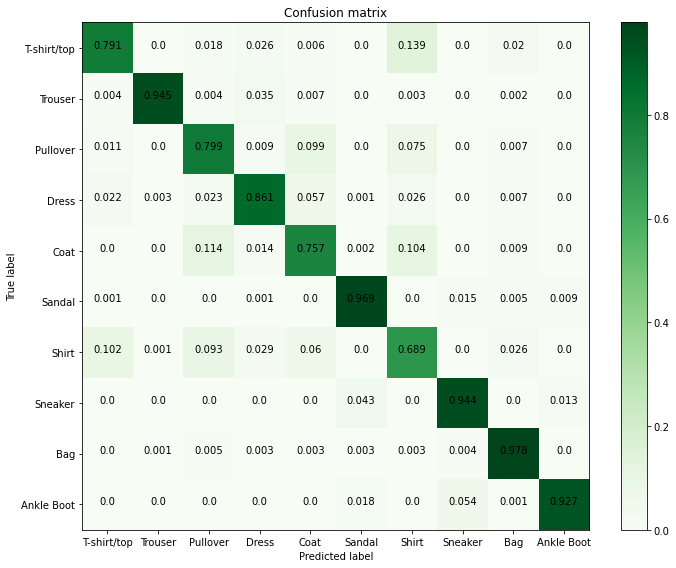

In [11]:
conf_mat_plot = plot_conf_mat(true_labels, prediction_labels)
writer.add_figure('Confusion matrix', conf_mat_plot)

#### Visualizing samlpes

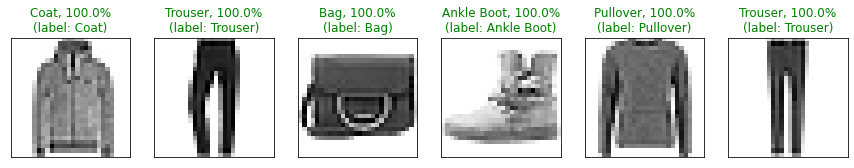

In [12]:
sample_images_plot = plot_classes_preds(testset.data, prediction_probs, prediction_labels, true_labels, sample_size, classes)
writer.add_figure('Prediction vs Labels', sample_images_plot)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir './simple-MLP' --host localhost

## MLP with Dropout
This network is the same as the simple MLP model except that has a dropout layer with p=0.4 after linear layers.

In [13]:
dp = 0.4
layers = [nn.Flatten(), nn.Linear(28 * 28, 256), nn.Tanh(), nn.Dropout(p=dp), nn.Linear(256, 128), nn.Tanh(), nn.Dropout(p=dp), nn.Linear(128, 100), nn.Tanh(), nn.Dropout(p=dp), nn.Linear(100, 10), nn.Softmax(dim=1)]
network = nn.Sequential(*layers)
criterion = nn.CrossEntropyLoss()
MLP_with_dropout_model = MLPModel(network, criterion)

In [14]:
MLP_with_dropout_model.fit(trainset, BATCH_SIZE, N_EPOCH)

Epoch 1:
Accuracy: 0.7953666666666667
Epoch 2:
Accuracy: 0.8060833333333334
Epoch 3:
Accuracy: 0.81835
Epoch 4:
Accuracy: 0.8025333333333333
Epoch 5:
Accuracy: 0.8490166666666666
Epoch 6:
Accuracy: 0.8639166666666667
Epoch 7:
Accuracy: 0.8732333333333333
Epoch 8:
Accuracy: 0.87505
Epoch 9:
Accuracy: 0.863
Epoch 10:
Accuracy: 0.875
Epoch 11:
Accuracy: 0.87785
Epoch 12:
Accuracy: 0.8618333333333333
Epoch 13:
Accuracy: 0.8881166666666667
Epoch 14:
Accuracy: 0.8675
Epoch 15:
Accuracy: 0.8913
Epoch 16:
Accuracy: 0.8764166666666666
Epoch 17:
Accuracy: 0.8844666666666666
Epoch 18:
Accuracy: 0.8896
Epoch 19:
Accuracy: 0.8906833333333334
Epoch 20:
Accuracy: 0.8960833333333333


In [15]:
print('Model performance on test set: ')
MLP_with_dropout_model.evaluate(testset, testset.data.size(0))

Model performance on test set: 
Accuracy: 0.8694


### Question
* What is the effect of dropout? (Search about this in the internet and breifly describe it.)

Answer:

Dropout has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. Also, Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs. This conceptualization suggests that perhaps dropout breaks-up situations where network layers co-adapt to correct mistakes from prior layers, in turn making the model more robust. In other words,dropout prevents model from over-fitting and improves its performance on test data.